In [1]:
import os
os.chdir('../')
import time
#time.sleep(100*60)
import matplotlib.pyplot as plt 
import os
import torch
import numpy as np
import torch.nn as nn
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
import random 
from decimal import Decimal
import warnings
import torch.nn.functional as F
from functools import partial
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from ultils.deepwave_fp import Physics_deepwave
from parameters_efwi import *
from ultils.utils import *
from kan_model.unet import U_Net
from kan_model.kan_unet import KANU_Net

The number of available GPUs is: 1
The selected GPU device is: NVIDIA GeForce RTX 3090
NT: 800
offsetx: 8020
depth: 2560
N_RECEIVERS: 375


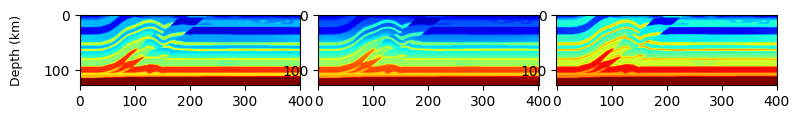

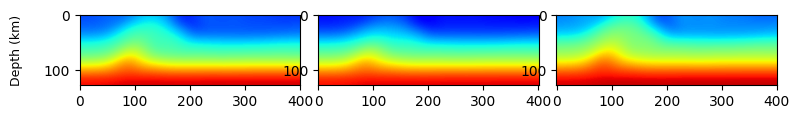

In [2]:
vp_true,vs_true,rho_true = load_true_models(path_vp_true, path_vs_true, path_rho_true)
vp_true,vs_true,rho_true = vp_true.to(DEVICE), vs_true.to(DEVICE), rho_true.to(DEVICE)
fig, ax = plt.subplots(1, 3, figsize=(9, 12))
fig1 = ax[0].imshow(vp_true.cpu().numpy(), cmap= 'jet',vmin = vp_true.min(),vmax = vp_true.max())
ax[0].set_ylabel("Depth (km)\n",fontsize=9)
fig2 = ax[1].imshow(vs_true.cpu().numpy(), cmap= 'jet',vmin = vs_true.min(),vmax = vs_true.max())
fig3 = ax[2].imshow(rho_true.cpu().numpy(), cmap= 'jet',vmin = rho_true.min(),vmax = rho_true.max())
plt.subplots_adjust(hspace=-0.84,wspace=0.08) 
plt.show()

vp_initial, vs_initial, rho_initial = load_init_models(path_vp_init,path_vs_init,path_rho_init)

fig, ax = plt.subplots(1, 3, figsize=(9, 12))
fig1 = ax[0].imshow(vp_initial.cpu().numpy(), cmap= 'jet',vmin = vp_true.min(),vmax = vp_true.max())
ax[0].set_ylabel("Depth (km)\n",fontsize=9)
fig2 = ax[1].imshow(vs_initial.cpu().numpy(), cmap= 'jet',vmin = vs_true.min(),vmax = vs_true.max())
fig3 = ax[2].imshow(rho_initial.cpu().numpy(), cmap= 'jet',vmin = rho_true.min(),vmax = rho_true.max())
plt.subplots_adjust(hspace=-0.84,wspace=0.08) 
plt.show()

torch.float32
wavelets shape: torch.Size([30, 1, 800])
torch.Size([30, 800, 375])


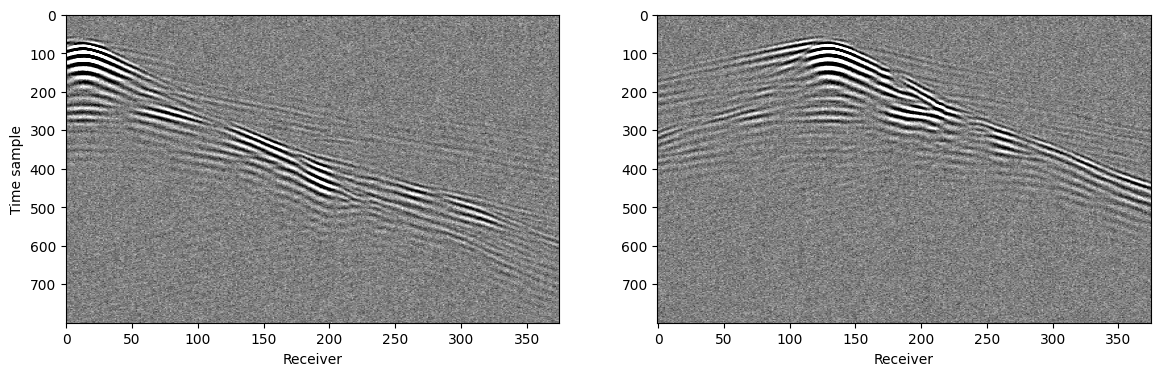

In [3]:
# load obs

# vx= torch.load('./obs_and_model_data/obs_vx.npy')
# vz= torch.load('./obs_and_model_data/obs_vy.npy')

if lack_low_fre == 'yes':
    src_new = seismic_filter(data=src_old.cpu(), \
                           filter_type='highpass',freqmin=cut_freq, \
                           freqmax=None,df=1/DT,corners=16)
    src_new = torch.tensor(src_new).to(torch.float32).to(DEVICE)
else:
    src_new = src_old
src_new = src_new.to(torch.float32).to(DEVICE)
print(src_new.dtype)
#print(vp_true.dtype)
print('wavelets shape:',src_new.shape)

physics = Physics(inpa['dh'], inpa['dt'],inpa['fdom'] ,size=deepwave_size,src=src_new,
                        src_loc=src_loc, rec_loc=rec_loc
                        )
taux_est = physics(vp_true,vs_true,rho_true)  
d_obs_vx = taux_est[0]
d_obs_vy = taux_est[1]


if noise_test == 'yes':
    d_obs_vx = add_gaussian_noise(d_obs_vx,noise_level = noise_level)
    d_obs_vy = add_gaussian_noise(d_obs_vy,noise_level = noise_level)
else:
    d_obs_vx = d_obs_vx
    d_obs_vy = d_obs_vy
    
##### show thses data
d_obs_vx_plot = d_obs_vx.squeeze(0)
d_obs_vy_plot = d_obs_vx.squeeze(0)
print(d_obs_vx_plot.shape)
vmin, vmax = torch.quantile(d_obs_vx_plot[10].to(DEVICE),
                            torch.tensor([0.01, 0.99]).to(DEVICE))
vsmin, vsmax = torch.quantile(d_obs_vy_plot[10].to(DEVICE),
                                 torch.tensor([0.01, 0.99]).to(DEVICE))


fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].imshow(d_obs_vx_plot[1].cpu().detach().numpy(), aspect='auto', cmap='gray',vmin=vmin, vmax=vmax)
ax[0].set_xlabel("Receiver")
ax[0].set_ylabel("Time sample")
ax[1].imshow(d_obs_vx_plot[10].cpu().detach().numpy(), aspect='auto', cmap='gray',vmin=vsmin, vmax=vsmax)
ax[1].set_xlabel("Receiver")
# ax[1].set_ylabel("Time sample")
plt.subplots_adjust(hspace=0.6) 
#plt.savefig(Fig_path+f"/obs&input_gather"+".jpg", dpi=900)  
plt.show()

In [4]:
vp_initial = vp_initial.to(DEVICE)
vs_initial = vs_initial.to(DEVICE)
rho_initial = rho_initial.to(DEVICE)
vp = vp_initial.requires_grad_(True)
vs = vs_initial.requires_grad_(True)
rho = rho_initial.requires_grad_(True)


criteria = torch.nn.L1Loss(reduction='sum')
model = KANU_Net(n_channels=1,n_classes=1,bilinear=True, device=DEVICE)#  U_Net(n_channels=1,n_classes=1)#  
model = model.to(DEVICE)
model.train()

lr = 1.0e-2
LR_MILESTONE = 550
optim_nnefwi = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.98, 0.999))
scheduler_optim_nnefwi = torch.optim.lr_scheduler.StepLR(optim_nnefwi, LR_MILESTONE, gamma=0.5)

###################################################################
##########                                               ##########
##########             NNEFWI WITH ADAM IS RUNNING       ##########
##########                                               ##########
##########                                               ##########
###################################################################
Iteration 10 = loss: 3509181.0000,model loss: 29253387.0000,time:6.25,snr_vp:20.586,snr_vs:20.640,snr_rho:32.244
Iteration 20 = loss: 3289811.2500,model loss: 28157079.2500,time:6.13,snr_vp:20.946,snr_vs:20.962,snr_rho:32.674
Iteration 30 = loss: 3219557.5000,model loss: 26571792.5000,time:5.97,snr_vp:21.062,snr_vs:21.160,snr_rho:32.699
Iteration 40 = loss: 3193270.7500,model loss: 26481356.7500,time:5.98,snr_vp:21.009,snr_vs:21.120,snr_rho:32.652
Iteration 50 = loss: 3161163.2500,model loss: 25907668.5000,time:5.98,snr_vp:21.105,snr_vs:21.282,snr_rho:32.796


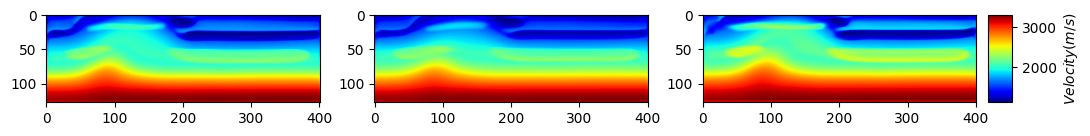

Iteration 60 = loss: 3135585.7500,model loss: 25234709.5000,time:5.96,snr_vp:21.326,snr_vs:21.467,snr_rho:32.907
Iteration 70 = loss: 3124735.2500,model loss: 24533073.3750,time:5.95,snr_vp:21.478,snr_vs:21.599,snr_rho:33.041
Iteration 80 = loss: 3101590.2500,model loss: 23931930.1250,time:5.97,snr_vp:21.634,snr_vs:21.719,snr_rho:33.046
Iteration 90 = loss: 3100739.7500,model loss: 23468702.5000,time:5.96,snr_vp:21.694,snr_vs:21.825,snr_rho:33.107
Iteration 100 = loss: 3091772.0000,model loss: 22860217.7500,time:5.96,snr_vp:21.848,snr_vs:22.032,snr_rho:33.075


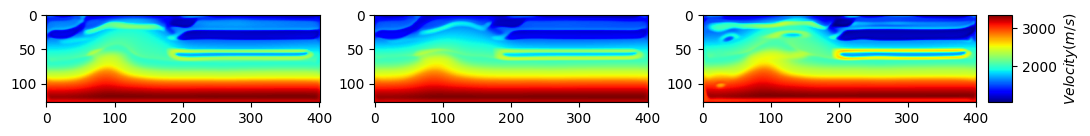

Iteration 110 = loss: 3087369.7500,model loss: 22082091.8750,time:5.97,snr_vp:22.034,snr_vs:22.289,snr_rho:33.492
Iteration 120 = loss: 3073062.0000,model loss: 21742664.5000,time:5.97,snr_vp:22.089,snr_vs:22.414,snr_rho:33.445
Iteration 130 = loss: 3059825.5000,model loss: 21302294.7500,time:5.97,snr_vp:22.190,snr_vs:22.593,snr_rho:33.497
Iteration 140 = loss: 3052190.0000,model loss: 20949432.5000,time:5.97,snr_vp:22.294,snr_vs:22.691,snr_rho:33.755
Iteration 150 = loss: 3049920.5000,model loss: 20170574.8750,time:5.97,snr_vp:22.533,snr_vs:22.991,snr_rho:33.949


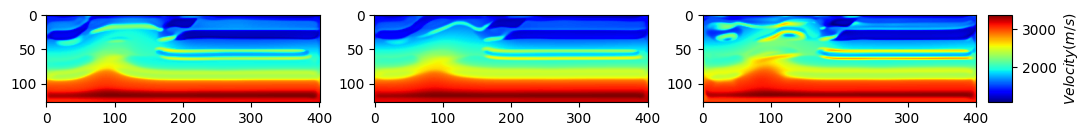

Iteration 160 = loss: 3042162.0000,model loss: 19570241.5000,time:5.97,snr_vp:22.785,snr_vs:23.346,snr_rho:34.279
Iteration 170 = loss: 3037733.5000,model loss: 18750251.7500,time:5.96,snr_vp:23.056,snr_vs:23.657,snr_rho:34.709
Iteration 180 = loss: 3030605.5000,model loss: 18102300.5000,time:5.97,snr_vp:23.368,snr_vs:23.964,snr_rho:34.866
Iteration 190 = loss: 3030028.2500,model loss: 17400418.0000,time:5.97,snr_vp:23.657,snr_vs:24.305,snr_rho:34.884
Iteration 200 = loss: 3024985.0000,model loss: 16713100.3750,time:5.96,snr_vp:23.947,snr_vs:24.525,snr_rho:35.255


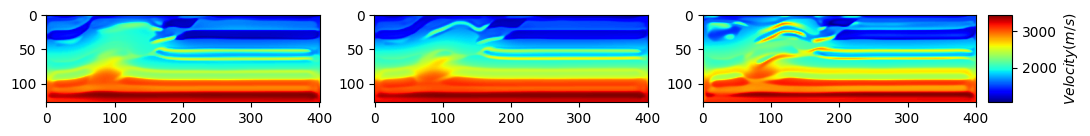

Iteration 210 = loss: 3020694.5000,model loss: 16453176.5000,time:5.97,snr_vp:24.041,snr_vs:24.686,snr_rho:35.154
Iteration 220 = loss: 3013570.2500,model loss: 15681992.5000,time:5.99,snr_vp:24.364,snr_vs:25.054,snr_rho:35.604
Iteration 230 = loss: 3007357.7500,model loss: 15363618.0000,time:5.97,snr_vp:24.402,snr_vs:25.180,snr_rho:35.604
Iteration 240 = loss: 3008292.5000,model loss: 15271663.7500,time:5.99,snr_vp:24.355,snr_vs:25.282,snr_rho:35.488
Iteration 250 = loss: 3007551.5000,model loss: 14992255.7500,time:5.97,snr_vp:24.611,snr_vs:25.455,snr_rho:35.688


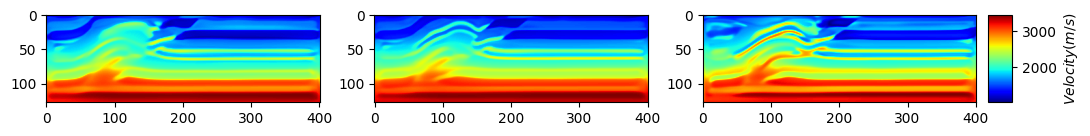

Iteration 260 = loss: 3010863.0000,model loss: 14373316.5000,time:5.96,snr_vp:24.669,snr_vs:25.763,snr_rho:36.019
Iteration 270 = loss: 2997029.0000,model loss: 14290920.2500,time:5.96,snr_vp:24.724,snr_vs:25.939,snr_rho:35.956
Iteration 280 = loss: 2996764.5000,model loss: 14004727.0000,time:6.05,snr_vp:24.997,snr_vs:26.173,snr_rho:35.783
Iteration 290 = loss: 2986976.5000,model loss: 13421544.1250,time:5.98,snr_vp:25.336,snr_vs:26.392,snr_rho:36.240
Iteration 300 = loss: 2984331.5000,model loss: 13198578.5000,time:5.99,snr_vp:25.478,snr_vs:26.633,snr_rho:36.057


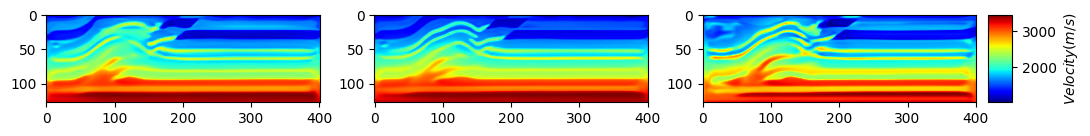

Iteration 310 = loss: 2982055.5000,model loss: 12994633.5000,time:5.94,snr_vp:25.521,snr_vs:26.941,snr_rho:35.818
Iteration 320 = loss: 2986366.7500,model loss: 12605838.8750,time:5.93,snr_vp:25.666,snr_vs:27.259,snr_rho:36.378
Iteration 330 = loss: 2987606.0000,model loss: 12288204.3750,time:5.94,snr_vp:26.005,snr_vs:27.346,snr_rho:36.383
Iteration 340 = loss: 2988735.0000,model loss: 12007395.5000,time:5.93,snr_vp:26.091,snr_vs:27.623,snr_rho:36.767
Iteration 350 = loss: 2985794.7500,model loss: 11840287.8750,time:5.93,snr_vp:26.128,snr_vs:27.849,snr_rho:37.051


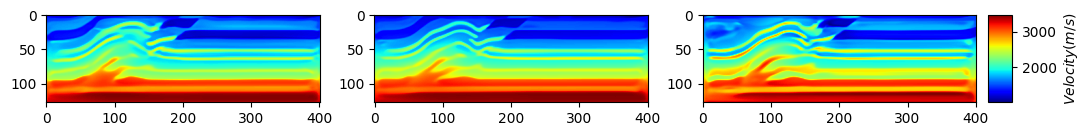

Iteration 360 = loss: 2982480.0000,model loss: 12004113.8750,time:5.93,snr_vp:26.023,snr_vs:27.775,snr_rho:36.434
Iteration 370 = loss: 2978973.7500,model loss: 11770558.6250,time:5.93,snr_vp:26.316,snr_vs:27.847,snr_rho:36.414
Iteration 380 = loss: 2978256.0000,model loss: 11489417.8125,time:5.93,snr_vp:26.456,snr_vs:28.123,snr_rho:36.844
Iteration 390 = loss: 2977859.0000,model loss: 11236416.5625,time:5.93,snr_vp:26.587,snr_vs:28.320,snr_rho:36.880
Iteration 400 = loss: 2979308.5000,model loss: 10999212.7500,time:5.94,snr_vp:26.676,snr_vs:28.548,snr_rho:37.040


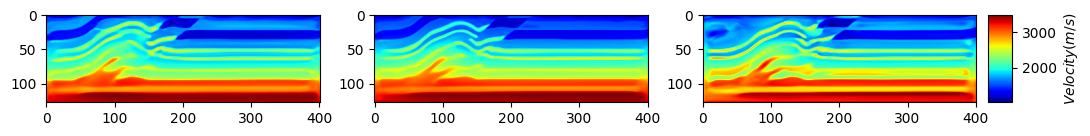

Iteration 410 = loss: 2977026.2500,model loss: 10858116.1250,time:5.93,snr_vp:26.773,snr_vs:28.702,snr_rho:36.947
Iteration 420 = loss: 2976369.2500,model loss: 10715580.6250,time:5.93,snr_vp:26.898,snr_vs:28.782,snr_rho:36.942
Iteration 430 = loss: 2976796.7500,model loss: 10611500.0000,time:5.96,snr_vp:27.010,snr_vs:28.897,snr_rho:36.886
Iteration 440 = loss: 2977591.5000,model loss: 10483479.3125,time:5.96,snr_vp:27.041,snr_vs:28.982,snr_rho:37.061
Iteration 450 = loss: 2977479.5000,model loss: 10431453.7500,time:5.97,snr_vp:27.016,snr_vs:29.037,snr_rho:37.017


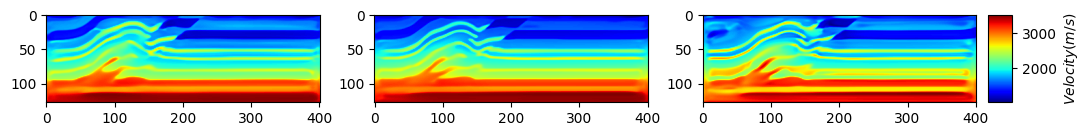

Iteration 460 = loss: 2976491.2500,model loss: 10347900.8125,time:5.97,snr_vp:27.201,snr_vs:29.133,snr_rho:37.133
Iteration 470 = loss: 2977309.0000,model loss: 10272727.2500,time:5.96,snr_vp:27.088,snr_vs:29.225,snr_rho:37.091
Iteration 480 = loss: 2978805.7500,model loss: 10235823.6250,time:5.96,snr_vp:27.146,snr_vs:29.238,snr_rho:36.974
Iteration 490 = loss: 2977261.7500,model loss: 10094511.3750,time:5.96,snr_vp:27.226,snr_vs:29.287,snr_rho:37.175
Iteration 500 = loss: 2975711.5000,model loss: 9992412.0625,time:5.97,snr_vp:27.403,snr_vs:29.360,snr_rho:37.195


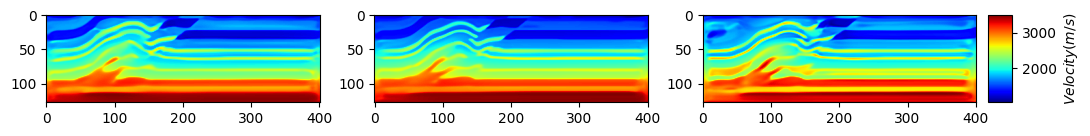

Iteration 510 = loss: 2974993.7500,model loss: 10020547.5000,time:5.96,snr_vp:27.276,snr_vs:29.462,snr_rho:37.001
Iteration 520 = loss: 2974638.0000,model loss: 9823841.8750,time:5.96,snr_vp:27.469,snr_vs:29.628,snr_rho:37.109
Iteration 530 = loss: 2974523.0000,model loss: 9662518.2500,time:5.96,snr_vp:27.607,snr_vs:29.717,snr_rho:37.150
Iteration 540 = loss: 2977424.5000,model loss: 9532971.3750,time:5.96,snr_vp:27.680,snr_vs:29.789,snr_rho:37.272
Iteration 550 = loss: 2975587.7500,model loss: 9593342.6250,time:5.96,snr_vp:27.575,snr_vs:29.770,snr_rho:37.259


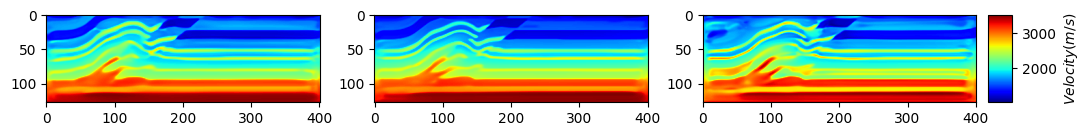

Iteration 560 = loss: 2974364.0000,model loss: 9503107.1250,time:5.96,snr_vp:27.677,snr_vs:29.852,snr_rho:37.277
Iteration 570 = loss: 2973960.2500,model loss: 9467033.2500,time:5.96,snr_vp:27.689,snr_vs:29.876,snr_rho:37.304
Iteration 580 = loss: 2973741.7500,model loss: 9402009.0000,time:6.07,snr_vp:27.738,snr_vs:29.953,snr_rho:37.227
Iteration 590 = loss: 2973581.0000,model loss: 9304242.8750,time:5.96,snr_vp:27.850,snr_vs:30.019,snr_rho:37.275


In [ ]:
### nnefwi loop

print("###################################################################")
print("##########                                               ##########")
print("##########             NNEFWI WITH ADAM IS RUNNING       ##########")
print("##########                                               ##########")
print("##########                                               ##########")
print("###################################################################")

for iter in range(total_iter):
    time_each_bath_start = time.time()
    loss_data, mp_sq, ms_sq,mrho_sq, model  = train_fun(
        Physics=Physics, 
        model=model,
        deepwave_size=deepwave_size,
        rho_initial=rho_initial,
        vx_initial=vp_initial,
        vy_initial=vs_initial,
        d_obs_vx=d_obs_vx,
        d_obs_vy=d_obs_vy,
        optim_nnefwi=optim_nnefwi, 
        criteria=criteria,
        mini_batches = mini_batches,
        src_loc=src_loc, 
        rec_loc=rec_loc, 
        src=src_new,
        inpa=inpa,
        vp_scale=vp_scale,
        vs_scale=vs_scale,
        rho_scale=rho_scale)

    all_loss_data.append(loss_data) 
    time_each_bath_end = time.time()
    time_each_iter.append(time_each_bath_end - time_each_bath_start)

    with torch.no_grad():
        all_loss_vx_model.append(
            criteria(mp_sq, vp_true).item()
        )
        all_loss_vy_model.append(
            criteria(ms_sq, vs_true).item()
        )
        all_loss_rho_model.append(
            criteria(mrho_sq, rho_true).item()
        )
        all_loss_model.append(
            criteria(mp_sq, vp_true).item() + criteria(ms_sq, vs_true).item()+ criteria(mrho_sq, rho_true).item()
        )
    snr_vp = ComputeSNR(mp_sq.detach().cpu().numpy(), \
                  vp_true.detach().cpu().numpy())
    SNR_vp = np.append(SNR_vp, snr_vp)
    snr_vs = ComputeSNR(ms_sq.detach().cpu().numpy(), \
                  vs_true.detach().cpu().numpy())
    SNR_vs = np.append(SNR_vs, snr_vs)
    snr_rho = ComputeSNR(mrho_sq.detach().cpu().numpy(), \
                  rho_true.detach().cpu().numpy())
    SNR_rho = np.append(SNR_rho, snr_rho)
 
    ssim_vp = ComputeSSIM(mp_sq.detach().cpu().numpy(), \
                  vp_true.detach().cpu().numpy())
    SSIM_vp = np.append(SSIM_vp, ssim_vp)
    ssim_vs = ComputeSSIM(ms_sq.detach().cpu().numpy(), \
                  vs_true.detach().cpu().numpy())
    SSIM_vs = np.append(SSIM_vs, ssim_vs)
    ssim_rho = ComputeSSIM(mrho_sq.detach().cpu().numpy(), \
                  rho_true.detach().cpu().numpy())
    SSIM_rho = np.append(SSIM_rho, ssim_rho)

    rerror_vp = ComputeRE(mp_sq.detach().cpu().numpy(), \
                  vp_true.detach().cpu().numpy())
    ERROR_vp = np.append(ERROR_vp, rerror_vp)
    rerror_vs = ComputeRE(ms_sq.detach().cpu().numpy(), \
                  vs_true.detach().cpu().numpy())
    ERROR_vs = np.append(ERROR_vs, rerror_vs)
    rerror_rho = ComputeRE(mrho_sq.detach().cpu().numpy(), \
                  rho_true.detach().cpu().numpy())
    ERROR_rho = np.append(ERROR_rho, rerror_rho)
    
    if (iter+1)%10 == 0:
        print(f"Iteration {iter + 1} = loss: {all_loss_data[-1]:.4f},model loss: {all_loss_model[-1]:.4f},time:{time_each_iter[-1]:.2f},snr_vp:{SNR_vp[-1]:.3f},snr_vs:{SNR_vs[-1]:.3f},snr_rho:{SNR_rho[-1]:.3f}")
        
    if (iter+1)%50 == 0:
        np.save(vp_nn_save_path + 'recx_iter_%s.npy' %(iter+1), mp_sq.cpu().detach().numpy(), 2)
        np.save(vs_nn_save_path + 'recx_iter_%s.npy' %(iter+1), ms_sq.cpu().detach().numpy(), 2)
        np.save(rho_nn_save_path + 'recx_iter_%s.npy' %(iter+1), mrho_sq.cpu().detach().numpy(), 2)
        fig, ax = plt.subplots(1,3,figsize=(12, 6))
        im0 = ax[0].imshow(mp_sq.squeeze(0).detach().cpu(), 
                          cmap="jet") 
        im1 = ax[1].imshow(ms_sq.squeeze(0).detach().cpu(), 
                          cmap="jet") 
        im2 = ax[2].imshow(mrho_sq.squeeze(0).detach().cpu(), 
                          cmap="jet") 
        points = ax[1].get_position().get_points()
        dy = points[1, 1] - points[0, 1]

        cax = fig.add_axes([0.91, points[0, 1], 0.02, dy])
        cax.yaxis.set_ticks_position("right")
        cbar = fig.colorbar(im1, cax=cax, orientation="vertical", 
                            extend="neither", label="$Velocity (m/s)$"
                            )
        plt.show()
    scheduler_optim_nnefwi.step()


In [ ]:
## save log_data
with torch.no_grad():
    np.savetxt(main_path_nn+'all_loss_data.txt', all_loss_data,delimiter=',')
    
    np.savetxt(main_path_nn+'all_loss_model.txt', all_loss_model, delimiter=',')
    np.savetxt(main_path_nn+'all_loss_vp_model.txt', all_loss_vx_model, delimiter=',')
    np.savetxt(main_path_nn+'all_loss_vs_model.txt', all_loss_vy_model, delimiter=',')
    np.savetxt(main_path_nn+'all_loss_rho_model.txt', all_loss_rho_model, delimiter=',')
    
    np.savetxt(main_path_nn+'vp_snr.txt', SNR_vp,delimiter=',')
    np.savetxt(main_path_nn+'vs_snr.txt', SNR_vs,delimiter=',')
    np.savetxt(main_path_nn+'rho_snr.txt', SNR_rho,delimiter=',')
    
    np.savetxt(main_path_nn+'vp_ssim.txt', SSIM_vp, delimiter=',')
    np.savetxt(main_path_nn+'vs_ssim.txt', SSIM_vs, delimiter=',')
    np.savetxt(main_path_nn+'rho_ssim.txt', SSIM_rho, delimiter=',')
    
    np.savetxt(main_path_nn+'error_vp.txt',ERROR_vp , delimiter=',')
    np.savetxt(main_path_nn+'error_vs.txt',ERROR_vs , delimiter=',')
    np.savetxt(main_path_nn+'error_rho.txt',ERROR_rho , delimiter=',')
    
    np.savetxt(main_path_nn+'time_unet.txt',time_each_iter , delimiter=',')